{'data_root': '/home/data',
 'deepmatch': '/home/deepmatching_1.2.2_c++/deepmatching-static',
 'graph_solver': '/home/cabbage/build/sample'}


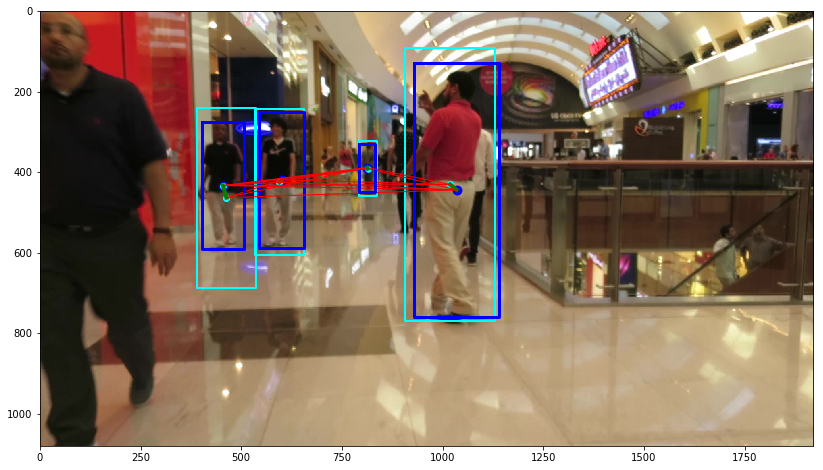

In [1]:
%matplotlib inline
import json
from pppr import aabb
from pprint import pprint
Settings = json.load(open('settings.txt'))
pprint(Settings)
import sys
sys.path.insert(0,'../')
from pak.datasets.MOT import MOT16
from pak import utils
import matplotlib.pyplot as plt
import numpy as np
from pak.evaluation import MOTA

root = Settings['data_root']

from experiments import MOT16_Experiments

mot16 = MOT16_Experiments(root)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

# --- SELECT THE RIGHT VIDEO ----
X  = mot16.mot16_11_X
Dt = mot16.mot16_11_true_detections_no_pid


VID_TYPE = '_mot16_11_dmax100'
E = np.loadtxt('edges' + VID_TYPE + '.txt')

def find_cost(i, j, E):
    for a, b, ce in E:
        if int(a) == int(i) and int(b) == int(j):
            return ce
    assert False

indx_frame1 = []
indx_frame2 = []
for idx, dt in enumerate(Dt):
    if dt[0] == 1:
        indx_frame1.append(idx)
    elif dt[0] == 2:
        indx_frame2.append(idx)

        
def get_center(aabb):
    _, x,y,w,h,_ = aabb
    return (x+w/2, y+h/2)
        
for j in indx_frame2:
    frame2, x, y, w, h, _ = Dt[j]
    assert frame2 == 2
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=2, c='cyan')
        

for i in indx_frame1:
    frame1, x, y, w, h, score = Dt[i]
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=3, c='blue')
    c_i = get_center(Dt[i])
    ax.scatter(c_i[0], c_i[1], color='blue', s=80)
    assert frame1 == 1
    for j in indx_frame2:
        c_j = get_center(Dt[j])
        ax.scatter(c_j[0], c_j[1], color='cyan', s=30)
        
        ce = find_cost(i, j, E)
        color = 'green' if ce > 0 else 'red'
        lw = 4 if ce > 0 else 1
        ax.plot([c_i[0], c_j[0]], [c_i[1], c_j[1]], color=color, lw=lw)


ax.imshow(X[1])
plt.show()

Unique ids: 30


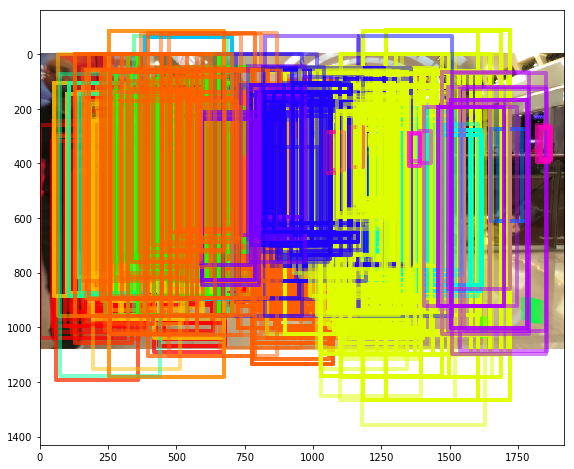

In [2]:
from numpy import genfromtxt
import numpy as np
from pak import utils
from cselect import color as cs

result = genfromtxt('build/result_mot16_11_dmax100.txt', delimiter=' ', dtype='uint32')

def extract_ids(result):
    #TODO: make this stuff better..
    
    candidates = []
    n = np.max(result[:,1])  # total number of nodes
    
    Nodes = [i for i in range(n+1)]
    
    
    for i, j, edge in result:
        assert(i < j)
        has_edge = edge == 0
        
        if has_edge:
            repres = Nodes[i]
            Nodes[j] = repres

    #print(Nodes)     
    return Nodes

Nodes = extract_ids(result)

# translate to sensible id's
n_unique = len(np.unique(Nodes))
lookup = {}
for new,old in zip(list(range(n_unique)), np.unique(Nodes)):
    lookup[old] = new

for i in range(len(Nodes)):
    Nodes[i] = lookup[Nodes[i]]

    
print("Unique ids:", n_unique)


colors = cs.lincolor(n_unique+3) # handling of circlular red

n = len(Nodes)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)

I = X[0]
ax.imshow(I)
for i in range(n):
    pid = Nodes[i]
    frame, x, y, w, h, score = Dt[i]
    c = colors[pid]/255
    assert frame < n
    
    bbX, bbY = utils.bb_to_plt_plot(x, y, w, h)
    ax.plot(bbX, bbY, linewidth=4, color=c, alpha=0.5)

    
plt.show()

In [3]:
# create video
import cv2
from os import makedirs, listdir
from os.path import join, isfile, isdir, exists, splitext
from random import shuffle

IGNORE = True
if not IGNORE:

    Dt = mot16.mot16_11_true_detections_no_pid
    n_unique = len(np.unique(Nodes))
    colors = cs.lincolor(n_unique+3) # handling of circlular red
    print("Unique ids:", n_unique)

    #shuffle(colors)
    np.random.shuffle(colors)

    factor = 0.5

    FRAMES_pred = {}
    n = len(Nodes)

    for i, (pid, data) in enumerate(zip(Nodes, Dt)):
        if i%100 == 0:
            print("handle " + str(i) + "/" + str(n))

        frame, x, y, w, h, score = data
        fname = '%06d' % (frame,) + '.jpg'
        if fname in FRAMES_pred:
            I = FRAMES_pred[fname]
        else:
            I = cv2.resize(X[int(frame)-1], None, fx=factor, fy=factor)
            FRAMES_pred[fname] = I

        x,y,w,h = int(x*factor),int(y*factor),\
            int(w*factor),int(h*factor)  # resize everything

        c = colors[pid]
        color = (int(c[0]), int(c[1]), int(c[2]))
        cv2.rectangle(I, (x,y), (x+w,y+h), color=color, thickness=4)
        cv2.putText(I, str(pid), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                    (255,255,255), thickness=10)
        cv2.putText(I, str(pid), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                    (255,0,0), thickness=3)


        #cv2.imwrite(join(data_loc, fname), I, cv2.IMWRITE_JPEG_QUALITY)


    data_loc = join(root, 'prediction_video_MOT16_11_dmax100')
    if not isdir(data_loc):
        makedirs(data_loc)

    for fname, I in FRAMES_pred.items():
        fname = join(data_loc, fname)
        cv2.imwrite(fname, cv2.cvtColor(I, cv2.COLOR_RGB2BGR))

    I = FRAMES_pred['000001.jpg']

    fig = plt.figure(figsize=(16,8))
    plt.imshow(I)
    plt.show()

In [4]:
IGNORE = True
if not IGNORE:
    FRAMES_gt = {}

    Gt = mot16.get_MOT16_11_gt_trajectories()
    n, _ = Gt.shape

    n_unique = int(np.max(Gt[:,1]))

    colors = cs.lincolor(n_unique+3) # handling of circlular red
    print("Unique ids:", n_unique)
    np.random.shuffle(colors)

    for i, (frame, pid, x, y, w, h) in enumerate(Gt):
        pid = int(pid)
        if i%100 == 0:
            print("handle " + str(i) + "/" + str(n))

        fname = '%06d' % (frame,) + '.jpg'
        if fname in FRAMES_gt:
            I = FRAMES_gt[fname]
        else:
            I = cv2.resize(X[int(frame)-1], None, fx=factor, fy=factor)
            FRAMES_gt[fname] = I

        x,y,w,h = int(x*factor),int(y*factor),\
            int(w*factor),int(h*factor)  # resize everything

        c = colors[int(pid)]
        color = (int(c[0]), int(c[1]), int(c[2]))
        cv2.rectangle(I, (x,y), (x+w,y+h), color=color, thickness=4)
        cv2.putText(I, str(pid), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                    (255,255,255), thickness=10)
        cv2.putText(I, str(pid), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                    (255,0,0), thickness=3)


        #cv2.imwrite(join(data_loc, fname), I, cv2.IMWRITE_JPEG_QUALITY)


    data_loc = join(root, 'gt_video_MOT16_11_dmax100')
    if not isdir(data_loc):
        makedirs(data_loc)

    for fname, I in FRAMES_gt.items():
        fname = join(data_loc, fname)
        cv2.imwrite(fname, cv2.cvtColor(I, cv2.COLOR_RGB2BGR))

    I = FRAMES_gt['000001.jpg']

    fig = plt.figure(figsize=(16,8))
    plt.imshow(I)
    plt.show()

In [5]:
IGNORE = True
if not IGNORE:
    FRAMES_td = {}

    Hy = mot16.mot16_11_true_detections
    n, _ = Hy.shape

    for i, (frame, pid, x, y, w, h, _) in enumerate(Hy):
        pid = int(pid)
        if i%100 == 0:
            print("handle " + str(i) + "/" + str(n))

        fname = '%06d' % (frame,) + '.jpg'
        if fname in FRAMES_td:
            I = FRAMES_td[fname]
        else:
            I = cv2.resize(X[int(frame)-1], None, fx=factor, fy=factor)
            FRAMES_td[fname] = I

        x,y,w,h = int(x*factor),int(y*factor),\
            int(w*factor),int(h*factor)  # resize everything

        c = colors[int(pid)]
        color = (255, 0, 0)
        cv2.rectangle(I, (x,y), (x+w,y+h), color=color, thickness=4)

    data_loc = join(root, 'true_detection_video_MOT16_11_dmax100')
    if not isdir(data_loc):
        makedirs(data_loc)

    for fname, I in FRAMES_td.items():
        fname = join(data_loc, fname)
        cv2.imwrite(fname, cv2.cvtColor(I, cv2.COLOR_RGB2BGR))

    I = FRAMES_td['000001.jpg']

    fig = plt.figure(figsize=(16,8))
    plt.imshow(I)
    plt.show()

In [6]:
from cabbage.data.video import VideoData
from pak.evaluation import MOTA, MOTP


# calculate MOTA
Gt = mot16.get_MOT16_11_gt_trajectories()
vd = VideoData(Gt)
#Gt = vd.get_n_first_frames(10)

threshold = 0.5

# test against "TRUE" detections
Hy = mot16.get_MOT16_11_trajectories()  # true detections
result, info = MOTA.evaluate_aabb(Gt, Hy, threshold, info=True)

print('true detection')
print("\tResult:", result)
print("\tInfo:", info)

Hy_ = mot16.mot16_11_true_detections_no_pid
vd = VideoData(mot16.mot16_11_true_detections_no_pid)
#Hy_ = vd.get_n_first_frames(10)

Hy = []
assert Hy_.shape[0] == len(Nodes)
for (frame, x, y, w, h, score),pid in zip(Hy_, Nodes):
    Hy.append((frame, pid, x, y, w, h))
Hy = np.array(Hy)


result, info = MOTA.evaluate_aabb(Gt, Hy, threshold, info=True)

print('our prediction')
print("\tResult:", result)
print("\tInfo:", info)

true detection
	Result: 0.690595611285
	Info: {'FN': 414, 'FP': 573, 'IDSW': 0, 'GT': 3190}
our prediction
	Result: 0.689028213166
	Info: {'FN': 414, 'FP': 573, 'IDSW': 5, 'GT': 3190}


In [7]:
# MOTA on point trajectories
threshold = 600
Gt = mot16.get_MOT16_11_gt_trajectories(as_point=True)

Hy_ = mot16.mot16_11_true_detections
Hy = []
Hy_gt = []
assert Hy_.shape[0] == len(Nodes)
for (frame, pid_gt, x, y, w, h, score),pid in zip(Hy_, Nodes):
    Hy.append((frame, pid, x, y))
    Hy_gt.append((frame, pid_gt, x, y))
Hy = np.array(Hy)
Hy_gt = np.array(Hy_gt)

result_motp = MOTP.evaluate(Gt, Hy_gt, threshold)
result, info = MOTA.evaluate(Gt, Hy_gt, threshold, info=True)

print('true detection')
print("\tResult (MOTA):", result)
print("\tResult (MOTP):", result_motp)
print("\tInfo:", info)

result_motp = MOTP.evaluate(Gt, Hy, threshold)
result, info = MOTA.evaluate(Gt, Hy, threshold, info=True)

print('our prediction')
print("\tResult (MOTA):", result)
print("\tResult (MOTP):", result_motp)
print("\tInfo:", info)


true detection
	Result (MOTA): 0.700313479624
	Result (MOTP): 279.139213507
	Info: {'FN': 393, 'FP': 552, 'IDSW': 11, 'GT': 3190}
our prediction
	Result (MOTA): 0.699059561129
	Result (MOTP): 279.077376891
	Info: {'FN': 393, 'FP': 552, 'IDSW': 15, 'GT': 3190}


In [8]:
from pak.datasets.MOT import MOT16
from pak import utils

def get_visible_pedestrains(Y_gt):
    Y_gt_frame1 = utils.extract_eq(Y_gt, col=7, value=1)
    Y_gt_frame1 = utils.extract_eq(Y_gt_frame1, col=8, value=1)
    return Y_gt_frame1

Gt = mot16.get_MOT16_11_gt_trajectories(as_point=True)
Hy = mot16.mot16_11_true_detections
mot16_data = MOT16(root)
X, Y_det, Y_gt = mot16_data.get_train("MOT16-11", memmapped=True)

print("# Frames:\t\t", X.shape)
print("# Detections:\t\t", Y_det.shape)
print("# Gt:\t\t\t", get_visible_pedestrains(Y_gt).shape)
print("# True Detections:\t", Hy.shape)
print("# True Datections (gt):\t", Gt.shape)

# Gt = mot16.get_MOT16_11_gt_trajectories(as_point=True)
# total_nbr_

/home/data/MOT16 found :)
MOT16: load memmapped file /home/data/MOT16/train/MOT16-11/data.memmap
MOT16 X loaded
MOT16 Y_det loaded
MOT16 Y_gt loaded
# Frames:		 (900, 1080, 1920, 3)
# Detections:		 (8590, 10)
# Gt:			 (3190, 9)
# True Detections:	 (3349, 7)
# True Datections (gt):	 (3190, 4)


In [9]:
# # accuracy
# Gt = mot16.get_MOT16_11_trajectories()
# Hy = mot16.get_MOT16_11_trajectories()  # true detections
# print(Hy.shape)
# print(Gt.shape)

# def accuracy(Gt, Hy):
#     n, _ = Gt.shape
#     pid_lookup = {}
#     correct_counter = 0
#     for (f_gt, pid_gt, x_gt, y_gt, _, _), (f, pid, x, y, _, _) in zip(Gt, Hy):
#         assert int(f_gt) == int(f)
#         assert x_gt == x and y_gt == y
#         pid, pid_gt = int(pid), int(pid_gt)
#         if not pid in pid_lookup:
#             pid_lookup[pid] = pid_gt  # set lookup for first time
        
#         if pid_lookup[pid] == pid_gt:
#             correct_counter += 1
    
#     return correct_counter / n
    
# accuracy(Gt, Hy)